# Electromagnetic wave absorption by a plasma ramp
## Simulation

In [25]:
import em1d
import numpy as np
dt=0.028
tmax=170.

nx=8000
box=225

ndump=25

#Set up a plasma ramp
ramp_start=180
ramp_end  =305
density = em1d.Density( type = "ramp", start = ramp_start, end = ramp_end, ramp = [0,150.0] )

#create an electron plasma species
sp_name="electrons"
ppc = 2 # Particles per cell
electrons = em1d.Species( sp_name, -1.0, ppc,density=density)

#initialize the arrays that will store the charge density and the field values
charge=[]
field=[]

# Diagnostics - this function is called at each time step of the simulation
def rep( sim ):
    if ( sim.n % ndump == 0 ):
        # Z component of electric field 
        field.append(np.array(sim.emf.Ez))
        
        # Charge density
        charge.append(np.array(electrons.charge()))

# Initialize simulation data
sim = em1d.Simulation( nx, box, dt, species=electrons, report = rep )

# Add laser pulse
sim.add_laser( em1d.Laser( start = 175.0, fall = 5.0,flat=145,rise=25, a0 = 0.000001, omega0 = 6.0, polarization = np.pi/2 ))

# Select open boundary conditions
sim.emf.bc_type = "open"

In [26]:
# Run the simulation
sim.run( tmax )


Running simulation up to t = 170 ...
n = 6072, t = 170.016
Done.


## Result analyser

First you need to select the data files that correspond to your simulation using the file chooser below.
<br> You may also specify the data type (*e.g* "charge")

You can also choose to plot a single quantity or two at the same time on the "Settings" tab.



### Visualization

Here you can use the slider to advance or go backwards in time

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ipywidgets import interactive, widgets, fixed

#create the x dimension array
x=np.linspace(0,box,nx)

fig=plt.figure()
def f(it):      #this function is called everytime the slider is updated  
    ax=plt.gca()
    #plot the field
    ax.plot(x, field[it])
    ax.set_xlabel("$x_1\;[c/\omega_p]$")
    ax.set_ylabel("$E_3\;[m_e c \\omega_p e^{-1}]$")
    
    ax2=ax.twinx()
    #plot the electron density
    ax2.plot(x, -charge[it],c="C1")
    ax2.set_ylabel("$density\;[n_0]$")
    
    #update the horizontal limits of the plot by changing the following line
    ax2.set_xlim([100,225])
    ax.grid()
    ax.set_title("Iteration: {} /".format(it*ndump)+"Time: {:.4}[$1/\omega_p$] ".format(it*ndump*dt))

interactive_plot = interactive(f, it=(0, len(charge)))

interactive_plot

interactive(children=(IntSlider(value=121, description='it', max=243), Output()), _dom_classes=('widget-intera…

<Figure size 432x288 with 0 Axes>

# Comparison with expected results

The theory behind elctromagnetic wave absorption by a plasma tells us that the <br>
the wave can penetrate the plasma up until a given length which depends btoh <br>
on the frequency of the wave and the plasma density. This length is called the<br>
penetration length:<br>

$\large{\delta=\frac{c}{\sqrt{\omega_{pe}^2-\omega^2}}}=\frac{1}{k}$

this happens only if the wave's frequency is smaller than the plasma frequency, $\omega_{pe}$, <br>
if on the other hand, the wave's frequency is larger than the plasma frequency, the <br> wave is
able to propagate normally.

Therefore, if the the plasma density is not constant (*e.g* increasing density) the <br>
wave may propagate normally up until a certain point and then start  decaying, <br> as shown in
the next figure:

<img src="ex.png"  style="width: 50%; float: left;" />

The shape of the wave function is described by the Airy function, given by:

$ Ai(z)={\large \frac{1}{\pi}}{\large\int_0^\infty}\cos{\left({\large \frac{t^3}{3}}-z t\right)}dt $

where $z=\left({\large \frac{\omega}{c\sqrt{L}}}\right)^{2/3}(x-L)=\beta^{2/3}(x-L)$ for a collionless plasma with density $n(x)=n_c\large\frac{x}{L}$. <br>Where $L$ is the distance form the beginniig of the plasma until the critical density point

\*$n_c$ is the critical density for the wave frequency $\omega$, *i.e.*, the densty for which <br> the wave no longer propagates and starts to be absorbed

The Airy Function can be approximated by more treatable functions like <br>
cosines (for the left part) and exponentials (for the right part), however, the <br> transition 
region is poorly approximated by any of these functions as you can see below:
<img src="Mplwp_airyai_asymptotic.svg"  style="width: 50%; float: left;" />

You can find out more about the Airy Function on its wikipedia page 
(https://en.wikipedia.org/wiki/Airy_function) <br>
but for now all you need to know is that the approxiamtion  goes as follows: <br>

$ Ai(z)\simeq{\large \frac{1}{\pi^{1/2}(-z)^{1/4}}}\cos{\left({{\large\frac{2}{3}}(-z)^{3/2}}-{\large\frac{\pi}{4}}\right)}dt, \;\;\text{for}\;z\ll -1$ 


$ Ai(z)\simeq{\large \frac{1}{\pi^{1/2}(z)^{1/4}}}\exp{\left({{\large-\frac{2}{3}}(z)^{3/2}}\right)}dt, \;\;\text{for}\;z\gg 1$ 


The function is defined below:

In [28]:
def Emfun(x, beta, L,E0):
    y=np.zeros(len(x))
    for i, xi in enumerate(x): 
        if xi <= L:
            y[i] =  E0/(np.sqrt(np.pi*np.sqrt(-beta*(xi-L))))*np.cos(2/3*(-beta*(xi-L))**1.5-np.pi/4)
        elif xi >= L:
            y[i] = E0*0.5/np.sqrt(np.pi*np.sqrt(beta*(xi-L)))*np.exp(-2/3*(beta*(xi-L))**1.5)  
    return y

In order to verify this theory, you can either fit your simulation results to the Airy function, <br>
or directly compare to the expected results using the parameters that you defined on the inputdeck.

## Fit

Start by choosing an apropriate instant on your simulation (after the stationary regime has been established) <br>
using the first slider above. 

After that you must identify the region where the aproximations don't hold using the following tool


In [29]:
#select the data that is currently plotted in the cells above
chrg_data=charge[interactive_plot.children[0].value]
emf_data =field[interactive_plot.children[0].value]

#find the position in the x-array where the ramp starts
itl=int(ramp_start/box*nx)
xmin=x[itl]

xmax=box

#create the 3 sliders that control the selection of the transition region
sldr1=widgets.FloatSlider(value=(xmin+xmax)/2,min=xmin,max=xmax,orientation='horizontal',description='x-axis limit:')        
sldr2=widgets.FloatSlider(value=(xmin+sldr1.value)/2,min=xmin,max=sldr1.value,orientation='horizontal',description='turning point:')
sldr3=widgets.FloatSlider(value=(xmax-xmin)/nx*5,min=(xmax-xmin)/(nx-int(ramp_start/box*nx)),max=(xmax-xmin)/10,orientation='horizontal',description='bar witdh:')


def regselect(maxx,itr,w,emf_data,datav,sldr): #this function is called everytime the sliders are moved  
    sldr.max=maxx
                    
    fig=plt.figure();
    plt.grid(alpha=0.6,linestyle='dashed')
    ax1=plt.gca()
    #plot the field values
    ax1.plot(x,emf_data,'.',c="darkorange");    
    ax1.set_xlim([xmin,maxx])
    ax1.set_xlabel("$x_1\;[c/\omega_p]$")
    ax1.set_ylabel("$E_3\;[m_e c \\omega_p e^{-1}]$")
    
    #plot the trasition region: a vertical line surrounded by a blue rectangle
    plt.axvline(x=itr,color='k')
    ymin=min(emf_data)
    ymax=max(emf_data)
    ylimin=ymin-(ymax-ymin)/10
    ylimax=ymax+(ymax-ymin)/10
    ax1.add_patch(patches.Rectangle((itr-w/2, ylimin),w,ylimax-ylimin,alpha=0.5))
    ax1.set_ylim([ylimin,ylimax])
    
    plt.show()

reg_selection=interactive(regselect,maxx=sldr1,itr=sldr2,w=sldr3,emf_data=fixed(emf_data),datav=fixed([]),sldr=fixed(sldr2))
reg_selection

interactive(children=(FloatSlider(value=202.5112514064258, description='x-axis limit:', max=225.0, min=180.022…

In [8]:
#Create new data arrays without the data points in the transition region.

#upper bound of the data
itu=int((reg_selection.children[0].value)/box*nx)
#turning point
center=reg_selection.children[1].value
#transition region width
w=reg_selection.children[2].value

#lower transition region bound
itll=int((center-w/2)/box*nx)
#upper transition region bound
ituu=int((center+w/2)/box*nx)

#new x array
nxx=x[itl:itll]-xmin
nxx=np.append(nxx,x[ituu:itu]-xmin)

#new data array
ndata=emf_data[itl:itll]
ndata=np.append(ndata,emf_data[ituu:itu])

In [9]:
a = widgets.FloatText(value=1,description=r'$\left(\omega/c\sqrt{L}\beta\right)^{2/3}$:')
b = widgets.FloatText(value=1,description='$L$:')
c = widgets.FloatText(value=1,description='$E_0$:')
ret=(widgets.VBox([a,b,c]),[a,b,c])
ret[0]

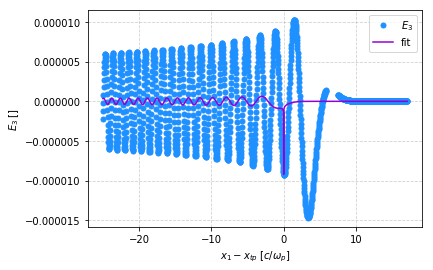

In [18]:
from scipy.optimize import curve_fit

fig=plt.figure();
plt.grid(alpha=0.6,linestyle='dashed')
ax1=plt.gca()
ax1.set_xlabel("$x_1-x_{tp}\;[c/\omega_p]$")
ax1.set_ylabel("$E_3\;[]$")

#retrieve the parameters from the upper boxes
param=ret[1]
par=[i.value for i in param]
#actually fit the data
popt, pcov = curve_fit(Emfun, nxx, ndata,p0=par)

#plot the original data points
ax1.plot(nxx-popt[1],ndata,'.',c="dodgerblue",ms=10,label="$E_3$");


#upate the parameters in the boxes
for i,b in enumerate(popt):
    param[i].value=b

ax1.plot(nxx-popt[1], Emfun(nxx, *popt), '-',c="darkviolet", label='fit')[0]

plt.legend()
plt.show()    

## Direct comparison

Once again, start by choosing an apropriate instant on your simulation (after the stationary regime has been established) <br>
using the first slider above. 

In [20]:
om = widgets.FloatText(value=1,description='$\omega$')
sl = widgets.FloatText(value=1,description='$slope$:')
ao = widgets.FloatText(value=1,description='$a_0$:')
dcomp= (widgets.VBox([om,sl,ao]),[om,sl,ao])

display(dcomp[0])

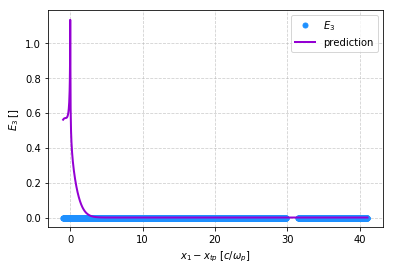

In [21]:
fig=plt.figure();
plt.grid(alpha=0.6,linestyle='dashed')

ax1=plt.gca()
dparam=dcomp[1]
#ax1.set_xlim([xmin,xmax])
ax1.set_xlabel("$x_1-x_{tp}\;[c/\omega_p]$")
ax1.set_ylabel("$E_3\;[]$")

L=(dparam[0].value**2)/dparam[1].value
A=(dparam[0].value/np.sqrt(L))**(2/3)
E0=(dparam[2].value*dparam[1].value)

par=[A,L,E0]

ax1.plot(np.array(nxx)-par[1],ndata,'.',c="dodgerblue",ms=10,label="$E_3$");
ax1.plot(np.array(nxx)-par[1], Emfun(nxx, *par), '-',c="darkviolet",lw=2, label='prediction')[0]

plt.legend()
plt.show()